In [1]:
import numpy as np
import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
import nengolib
from nengolib.signal import s, LinearSystem

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from nengo_bioneurons import BahlNeuron

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
def make_stimulus(signal, freq, amp, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: amp*np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: amp*np.sin(freq*t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=amp,
            seed=seed))

In [3]:
def norms(signal, freq, amp, ss, tau, t, plot=False):
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = make_stimulus(signal, freq, amp, ss)
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    if plot:
        plt.plot(sim.trange(), stimulus)
        plt.plot(sim.trange(), target)
        plt.plot(sim.trange(), lpf.filt(sim.data[p_integral]/norm_f))
        plt.show()
    return norm, norm_s, norm_f

In [4]:
def train_filter(spikes,
                 target,
                 method='hyperopt',
                 n_zeros=0,
                 n_poles=2,
                 z_min=0,
                 z_max=1,
                 p_min=-1e2,
                 p_max=-1e0,
                 reg=0.1,
                 max_evals=100,
                 seed=5,  # filter seed
                 ):
    
    if method == 'hyperopt':
#         print 'Running hyperopt ...'
        hyperparams = {}
        for z in range(n_zeros):
            hyperparams['zeros_%s'%z] = hp.uniform('zeros_%s'%z, z_min, z_max)
        for p in range(n_poles):
            hyperparams['poles_%s'%p] = hp.uniform('poles_%s'%p, p_min, p_max)
        hyperparams['n_zeros'] = n_zeros
        hyperparams['n_poles'] = n_poles
        hyperparams['spikes'] = spikes
        hyperparams['target'] = target

        def objective(hyperparams):
            zeros = np.array([hyperparams['zeros_%s'%z] for z in range(hyperparams['n_zeros'])])
            poles = np.array([hyperparams['poles_%s'%p] for p in range(hyperparams['n_poles'])])            
            h = nengolib.signal.LinearSystem((zeros, poles, 1.0))
            h /= h.dcgain
            
            act = h.filt(np.load(hyperparams['spikes'])['spikes'])
            target = np.load(hyperparams['target'])['target']
            d = nengo.solvers.LstsqL2(reg=reg)(act, target)[0]
            xhat = np.dot(act, d)
            if np.sum(target) != 0:
                nrmse = nengolib.signal.nrmse(xhat, target=target)
            else:
                nrmse = nengo.utils.numpy.rmse(xhat, target)
            
            return {'loss': nrmse,
                    'zeros': zeros,
                    'poles': poles,
                    'status': STATUS_OK }
        
        trials = Trials()

        best = fmin(objective,
                    rstate=np.random.RandomState(seed=seed),
                    space=hyperparams,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
        
        best_zeros = []
        best_poles = []
        for z in range(n_zeros):
            best_zeros.append(best['zeros_%s'%z])
        for p in range(n_poles):
            best_poles.append(best['poles_%s'%p])
        
        return best_zeros, best_poles

In [5]:
def bio_fb(
    d_supv_out,
    d_supv_bio,
    d_bio_out,
    d_bio_bio,
    h_supv=None,
    h_bio=None,
    t=1,
    n_neurons=10,
    signal='cos',
    freq=2*np.pi,
    amp=1,
    n_syns=1,
    sec='tuft',
    taus={'network': 0.1,
          'readout': 0.1},
    regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1,
          'bio-bio': 1.0,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'fs': 5},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    optimize_filter=False,
    verbose=True):

    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    h_lpf = nengo.Lowpass(taus['readout'])
    if h_supv is None:
        h_supv = h_lpf
    if h_bio is None:
        h_bio = h_lpf

    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seed=seeds['ss'])
        pre_u = nengo.Ensemble(radius=norm_s, **pre_kwargs)
        pre_x = nengo.Ensemble(radius=norm, **pre_kwargs)
        supv = nengo.Ensemble(**bio_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])
        # feed u into supv and bio
        nengo.Connection(pre_u, supv,
            transform=taus['network']/norm_f,
            solver=LstsqL2(reg=regs['pre_u-bio']),
            **conn_kwargs)
        nengo.Connection(pre_u, bio,
            transform=taus['network']/norm_f,
            solver=LstsqL2(reg=regs['pre_u-bio']),
            **conn_kwargs)
        # feed x into supervisor
        nengo.Connection(pre_x, supv,
            solver=LstsqL2(reg=regs['pre_x-bio']),
            transform=1.0/norm_f,
            **conn_kwargs)
        # feed x from supv to bio
        nengo.Connection(supv, bio, solver=NoSolver(d_supv_bio), **conn_kwargs)      
        # feed x from bio to bio
        nengo.Connection(bio, bio, solver=NoSolver(d_bio_bio), **conn_kwargs)
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)

        p_u = nengo.Probe(u, synapse=None)
        p_target = nengo.Probe(tar, synapse=None)
        p_act_supv = nengo.Probe(supv.neurons, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_supv = nengo.Probe(supv, synapse=h_lpf, solver=NoSolver(d_supv_out))
        p_bio = nengo.Probe(bio, synapse=h_lpf, solver=NoSolver(d_bio_out))
            
    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    times = sim.trange()
    stim = h_lpf.filt(sim.data[p_u])
    target = h_lpf.filt(sim.data[p_target])
    spikes_supv = sim.data[p_act_supv]
    spikes_bio = sim.data[p_act_bio]
    act_supv = h_supv.filt(spikes_supv)
    act_bio = h_bio.filt(spikes_bio)
    xhat_supv = sim.data[p_supv]
    xhat_bio = sim.data[p_bio]
    nrmse_supv = nengolib.signal.nrmse(xhat_supv, target=target)
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)  

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes_supv, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_supv), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        plt.tight_layout()

        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 8))
        ax3.plot(sim.trange(), target, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_supv, alpha=0.5,
            label='supv, nrmse=%.3f'%nrmse_supv)
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
            xlabel='time', ylabel='$\mathbf{x}$')
        ax3.legend(loc='lower left')
        plt.tight_layout()
        plt.show()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        plt.tight_layout()

        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 8))
        ax3.plot(sim.trange(), target, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_bio, alpha=0.5,
            label='bio, nrmse=%.3f'%nrmse_bio)
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
            xlabel='time', ylabel='$\mathbf{x}$')
        ax3.legend(loc='lower left')
        plt.tight_layout()
        plt.show()
        
        plt.show()

        if optimize_filter:
            file_supv = 'data/bio_fb_spikes_supv.npz'
            file_bio = 'data/bio_fb_spikes_bio.npz'
            file_target = 'data/bio_fb_target.npz'
            np.savez(file_supv, spikes=spikes_supv)
            np.savez(file_bio, spikes=spikes_bio)
            np.savez(file_target, target=target)
            
            zeros_supv, poles_supv = train_filter(file_supv, file_target, seed=seeds['fs'])
            zeros_bio, poles_bio = train_filter(file_bio, file_target, seed=seeds['fs'])
                                                                                  
            h_supv = LinearSystem((zeros_supv, poles_supv, 1.0))
            h_bio = LinearSystem((zeros_bio, poles_bio, 1.0))
            h_supv =  h_supv / h_supv.dcgain
            h_bio =  h_bio / h_bio.dcgain
                                                                                  
            act_supv = h_supv.filt(spikes_supv)
            act_bio = h_bio.filt(spikes_bio)
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            times = np.arange(0, 1e0, 1e-3)
            ax.plot(times, h_supv.impulse(len(times)), label='$h_{supv}$')
            ax.plot(times, h_bio.impulse(len(times)), label='$h_{bio}$')
            ax.plot(times, nengolib.Lowpass(taus['readout']).impulse(len(times)), label='lowpass')
            ax.legend()
            ax.set(xlabel='time (s)', ylabel='amplitude')
        
    d_supv_out_new = LstsqL2(reg=regs['bio-out'])(act_supv, target)[0]
    d_supv_bio_new = LstsqL2(reg=regs['bio-bio'])(act_supv, target)[0]
    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    d_bio_bio_new = LstsqL2(reg=regs['bio-bio'])(act_bio, target)[0]
    
    return d_supv_out_new, d_supv_bio_new, d_bio_out_new, d_bio_bio_new, h_supv, h_bio

Building finished in 0:00:02.                                                   
Simulating finished in 0:19:42.                                                 


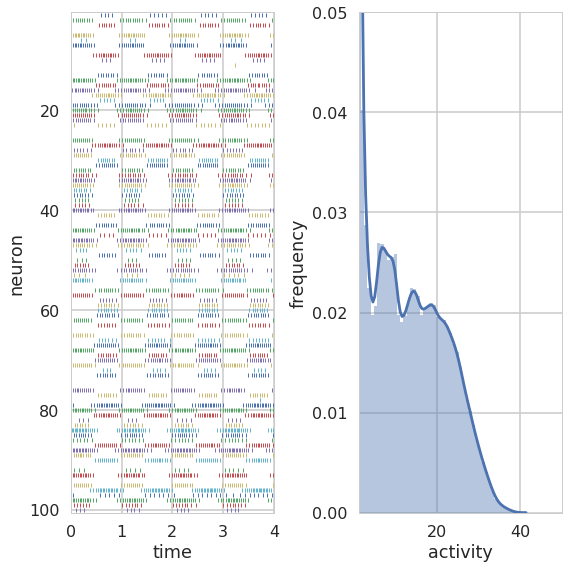

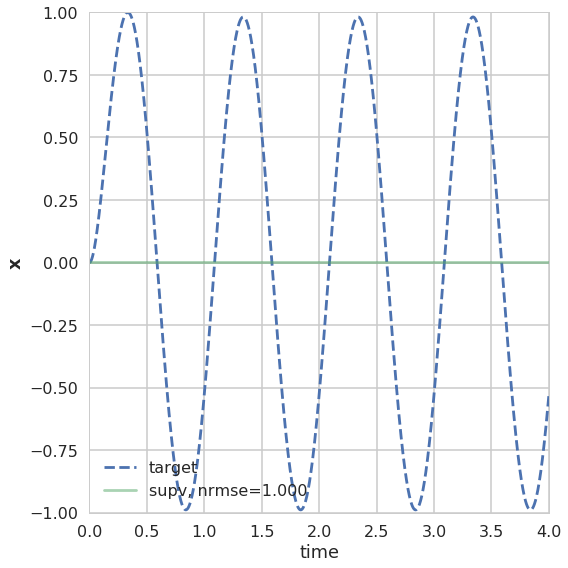

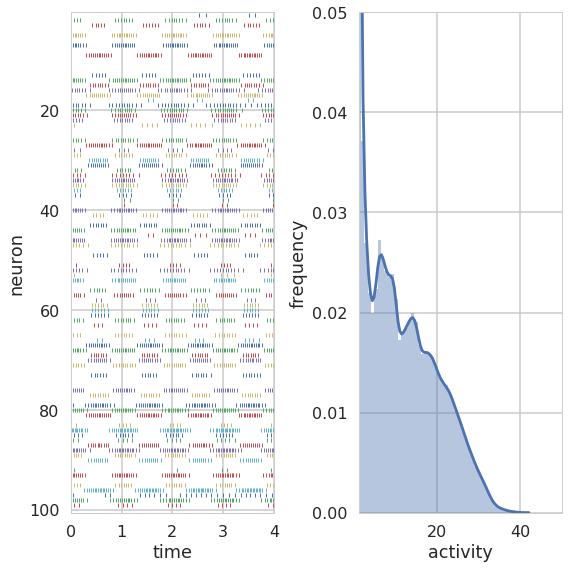

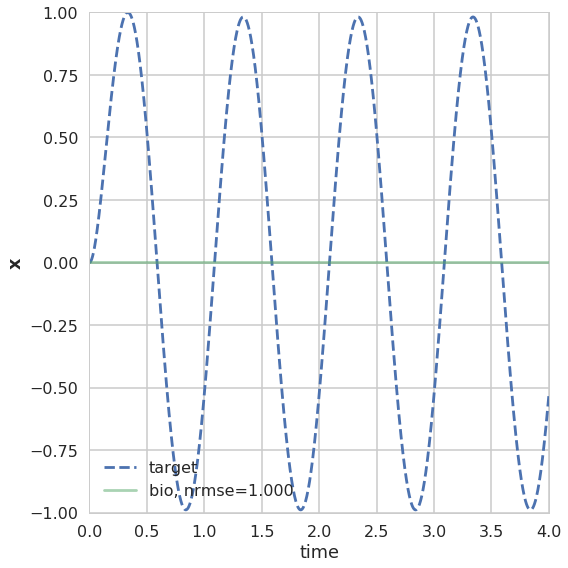

full supervision
Building finished in 0:00:02.                                                   
Simulating finished in 0:19:29.                                                 


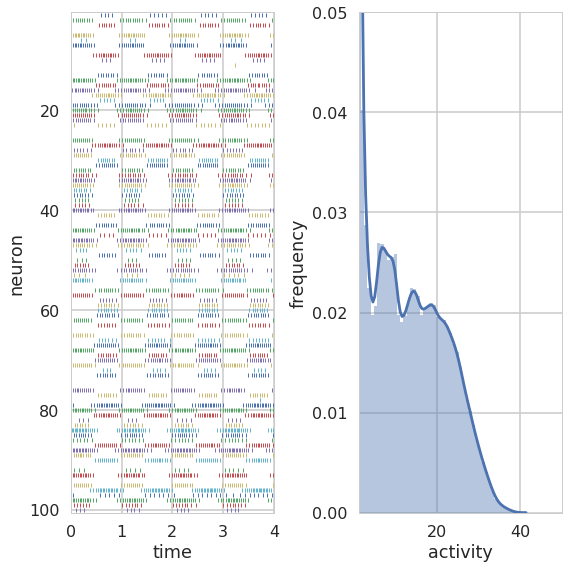

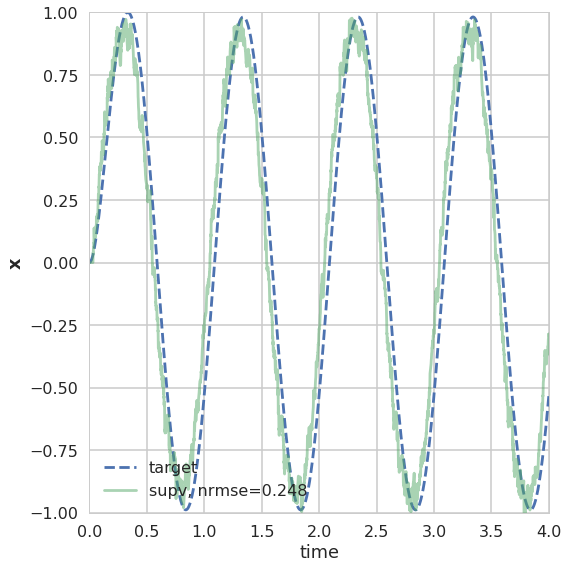

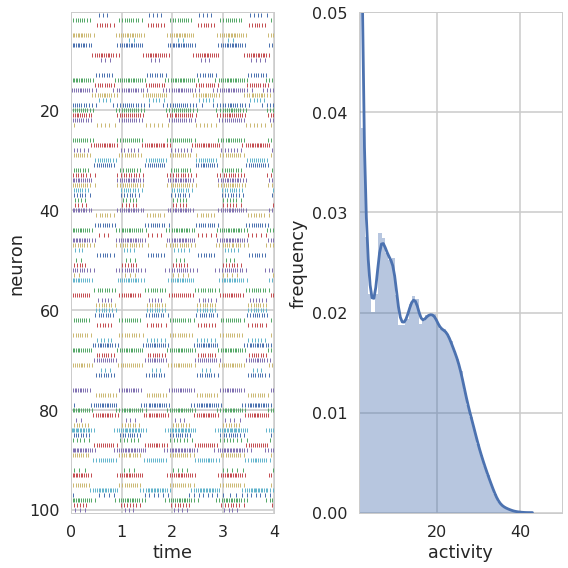

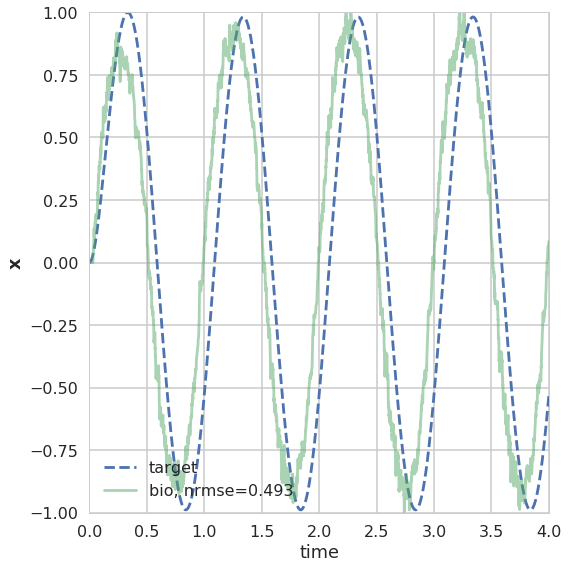

full recurrence, training signal
Building finished in 0:00:02.                                                   
Simulating finished in 0:21:39.                                                 


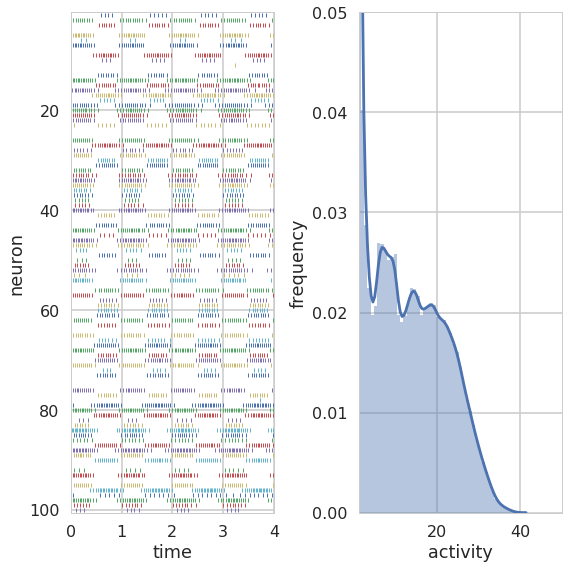

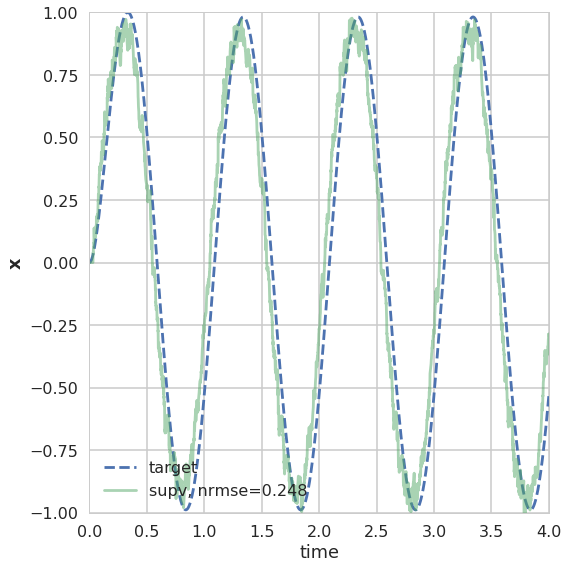

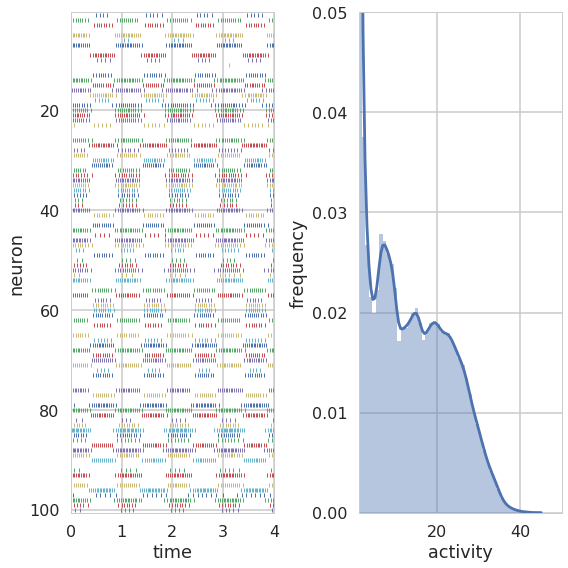

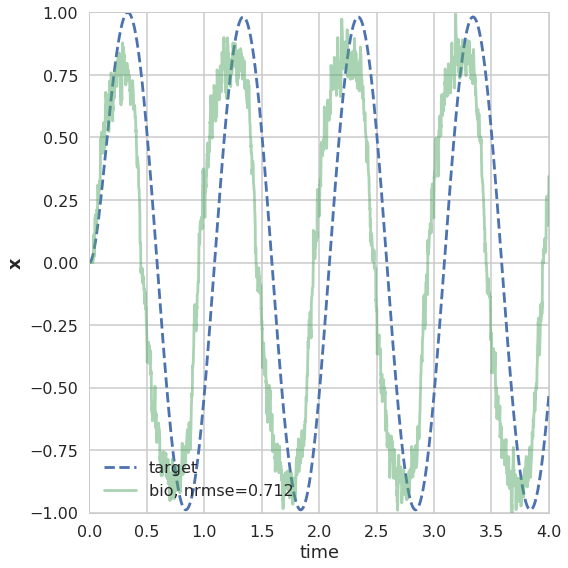

full recurrence, novel signal
Building finished in 0:00:02.                                                   
Simulating finished in 0:22:12.                                                 


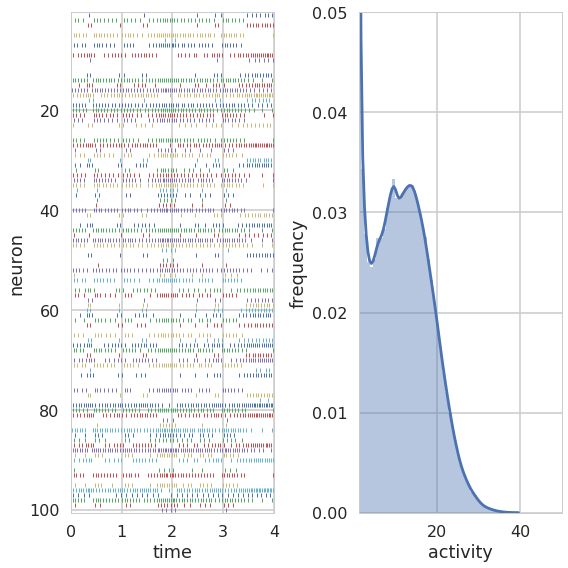

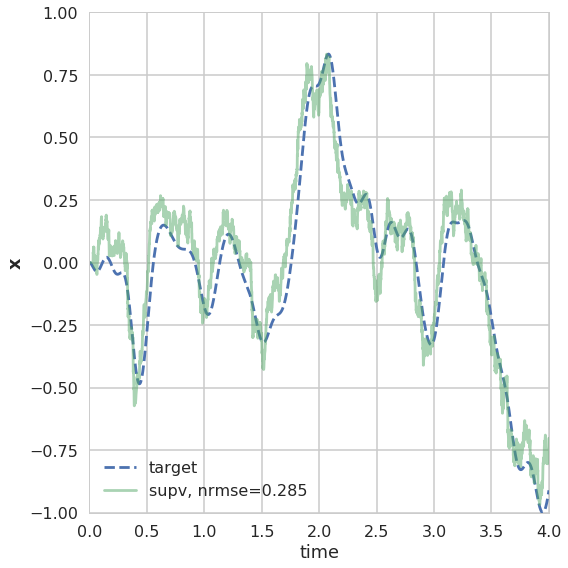

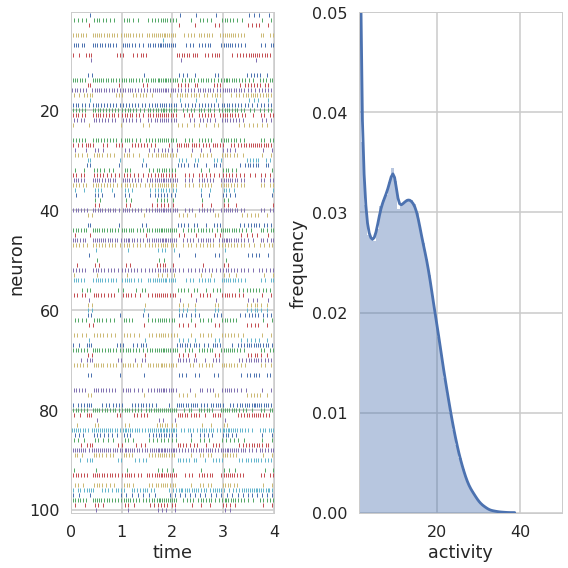

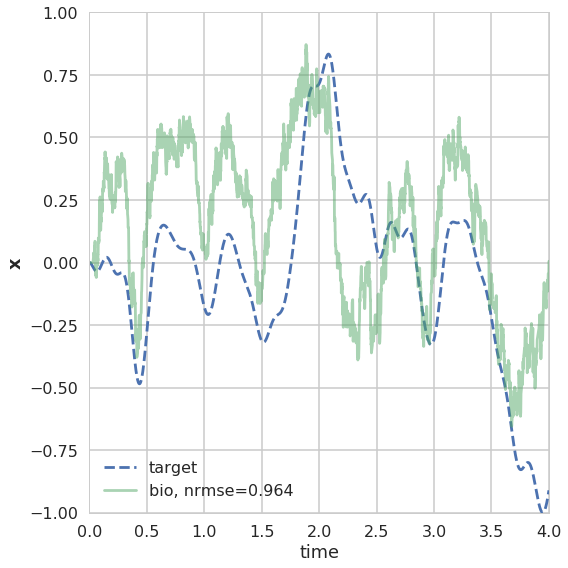

In [8]:
n_neurons = 100
t = 4
d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

d_supv_out, d_supv_bio, _, _, _, _ = bio_fb(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "full supervision"
_, _, d_bio_out, d_bio_bio, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "full recurrence, training signal"
_, _, _, _, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "full recurrence, novel signal"
_, _, _, _, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=4,
    signal='white_noise',
    verbose=True)

Building finished in 0:00:02.                                                   
Simulating finished in 0:24:05.                                                 


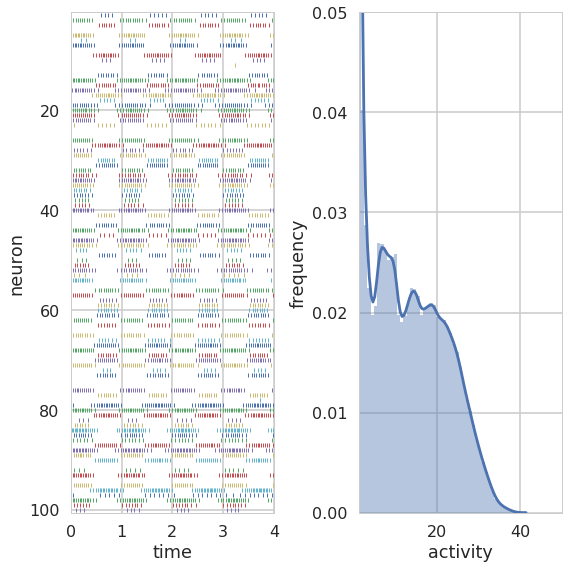

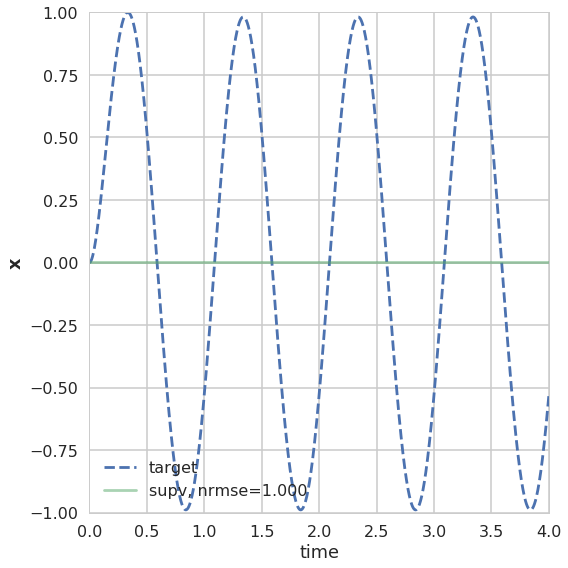

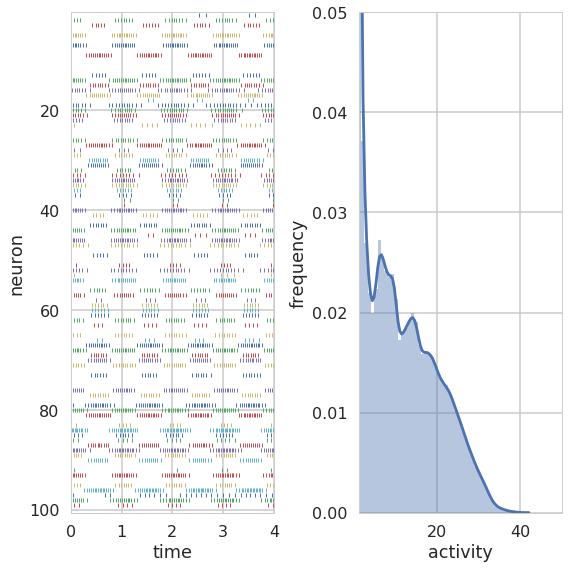

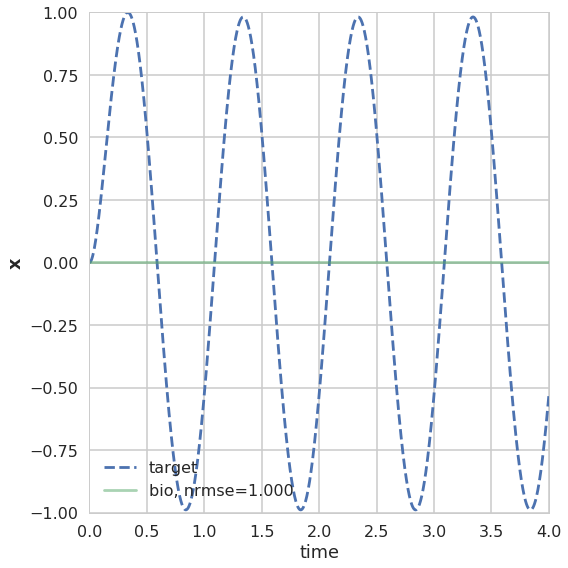

full supervision
Building finished in 0:00:02.                                                   
Simulating finished in 0:24:18.                                                 


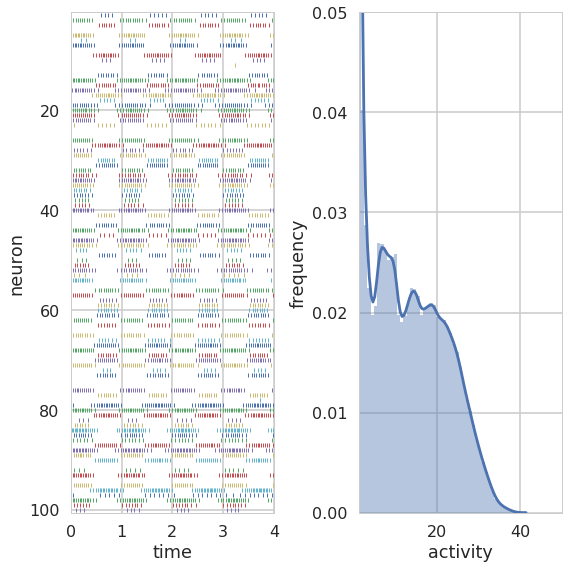

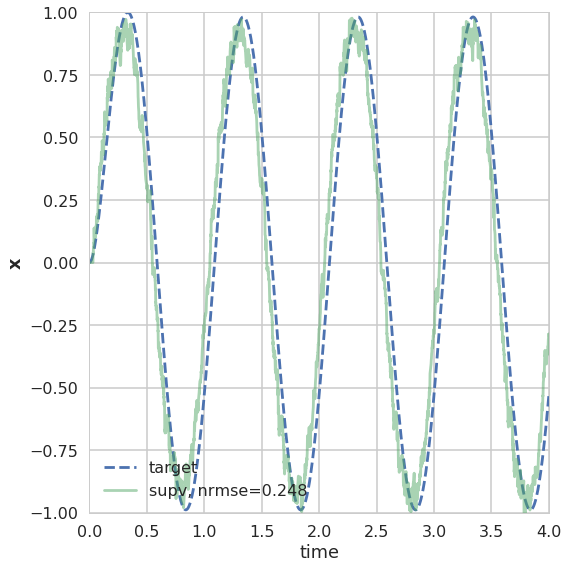

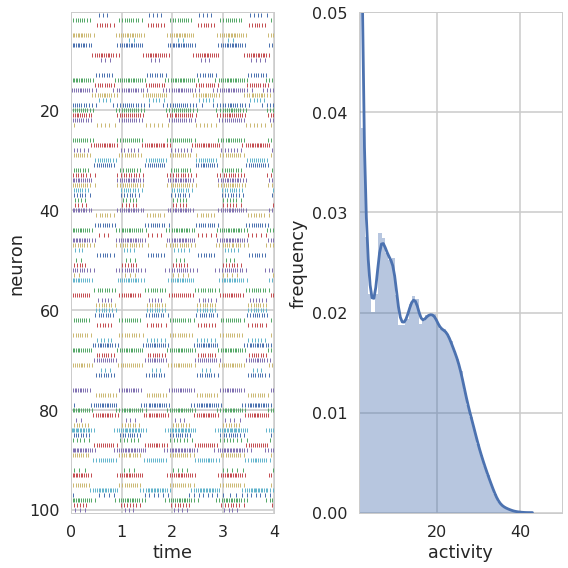

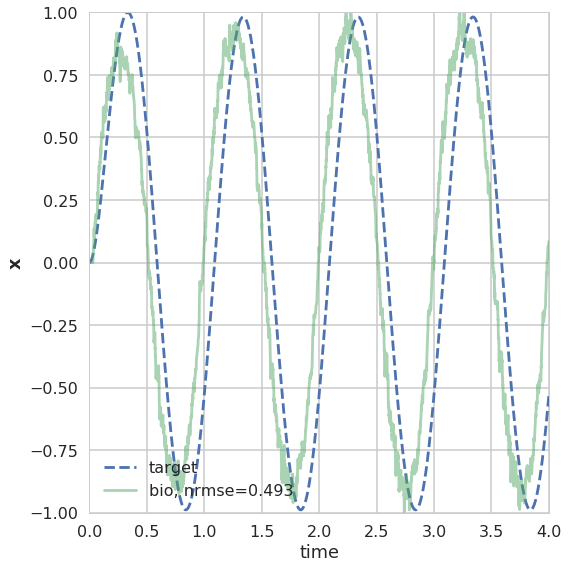

full recurrence, training signal
Building finished in 0:00:02.                                                   
Simulating finished in 0:28:16.                                                 


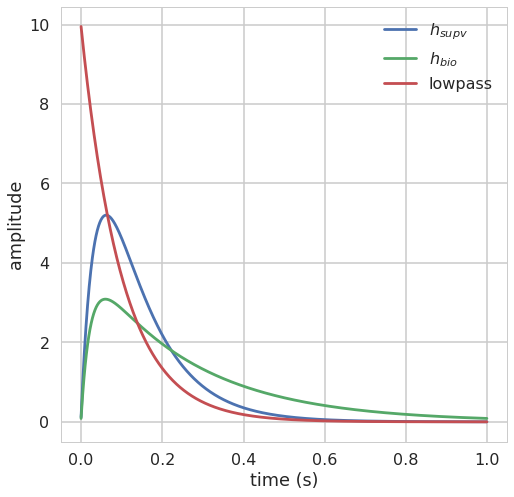

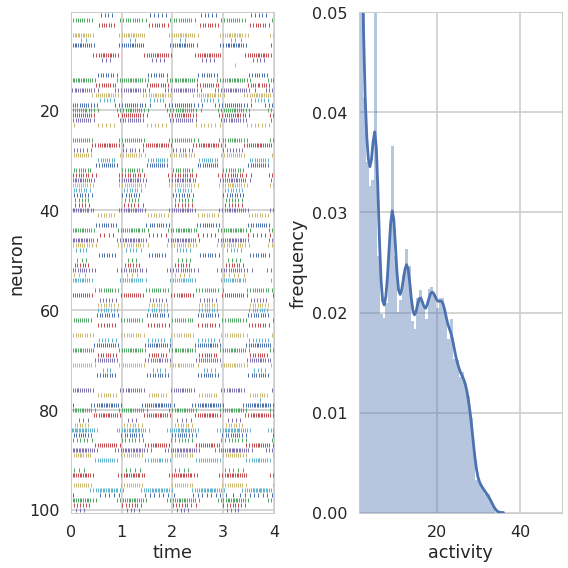

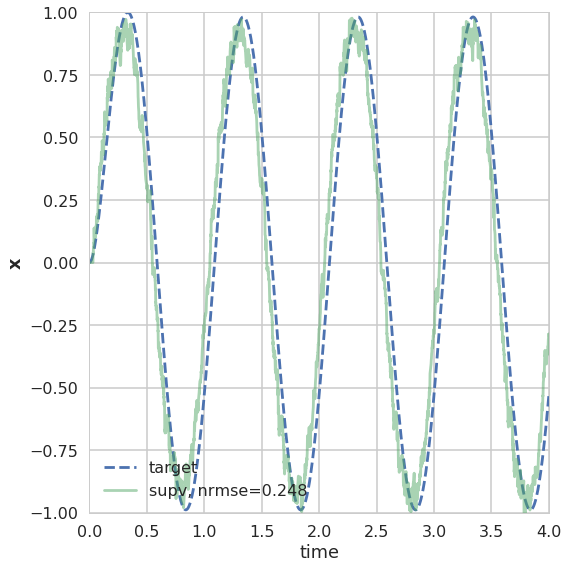

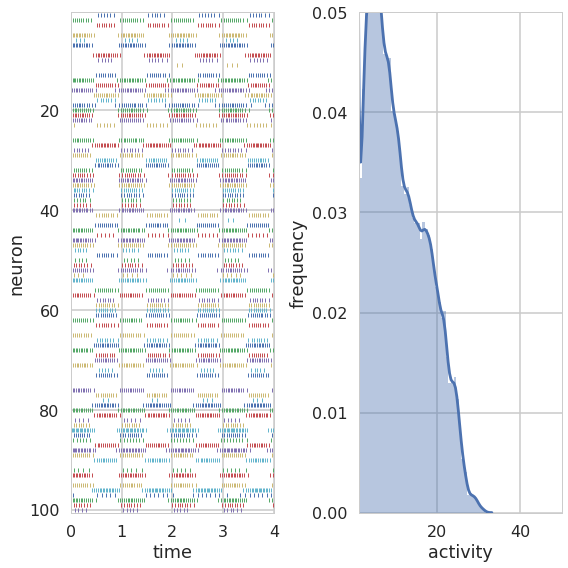

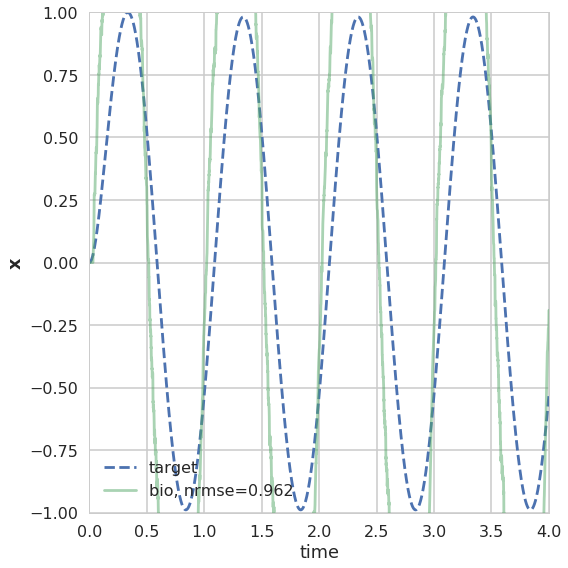

full recurrence, novel signal
Building finished in 0:00:02.                                                   
Simulating finished in 0:28:24.                                                 


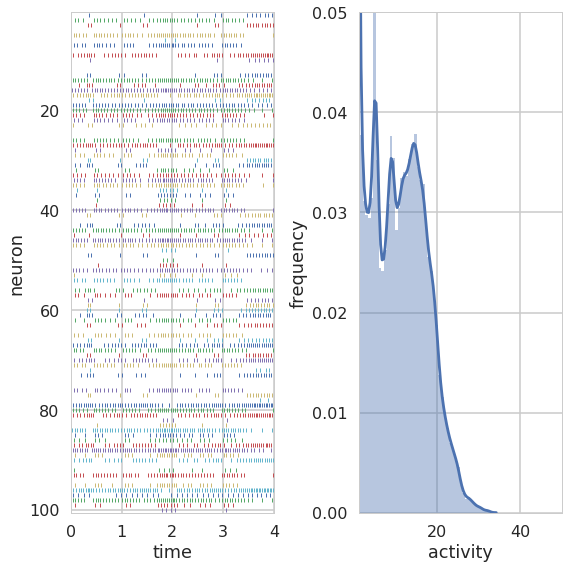

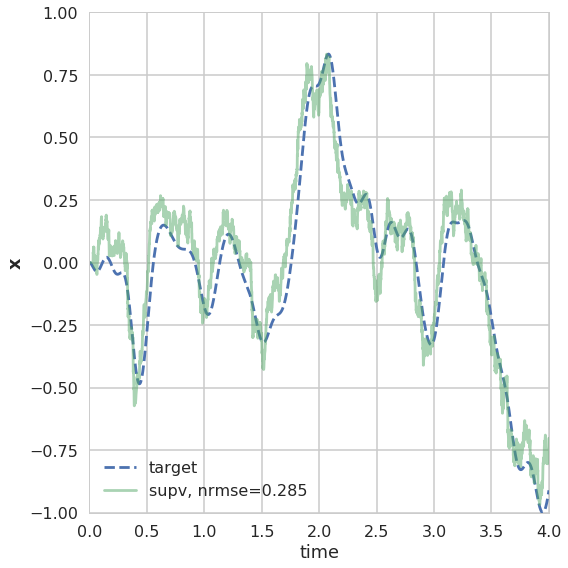

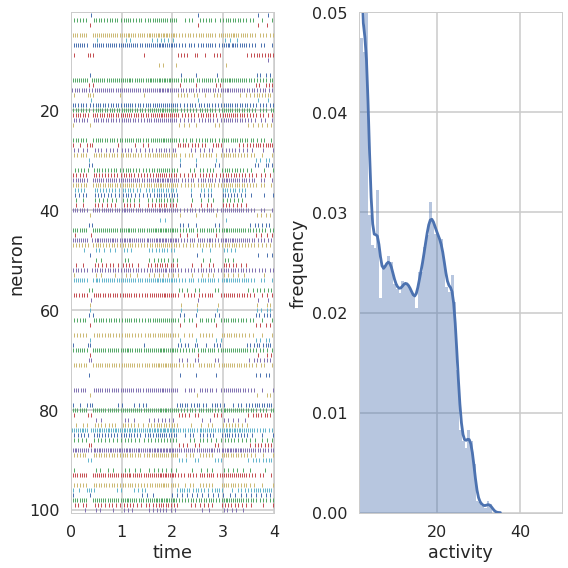

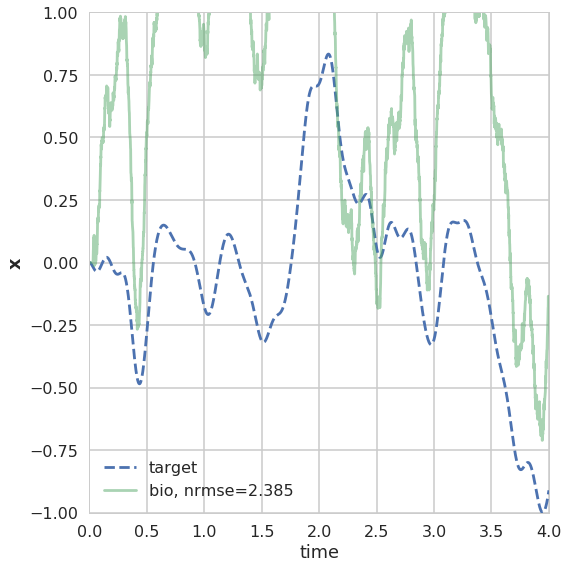

In [9]:
n_neurons = 100
t = 4
d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

d_supv_out, d_supv_bio, _, _, _, _ = bio_fb(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "full supervision"
_, _, d_bio_out, d_bio_bio, h_supv, h_bio = bio_fb(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    optimize_filter=True,
    verbose=True)

print "full recurrence, training signal"
_, _, _, _, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    h_supv=h_supv,
    h_bio=h_bio,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "full recurrence, novel signal"
_, _, _, _, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    h_supv=h_supv,
    h_bio=h_bio,
    n_neurons=n_neurons,
    t=4,
    signal='white_noise',
    verbose=True)

Try to increase accuracy while stull on "tuft"

Building finished in 0:00:07.                                                   
Simulating finished in 2:03:41.                                                 


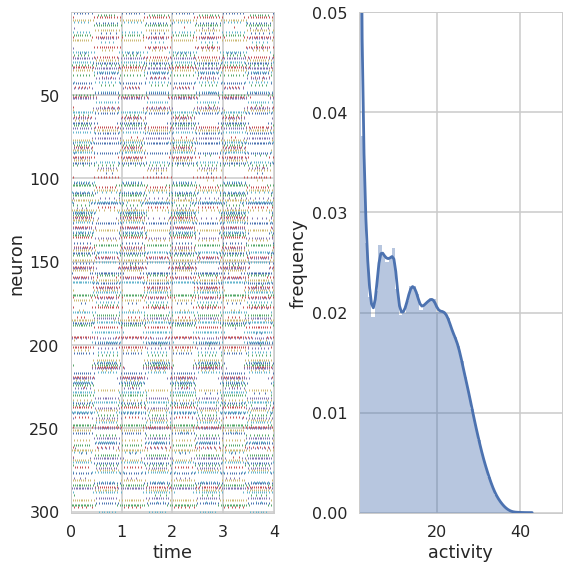

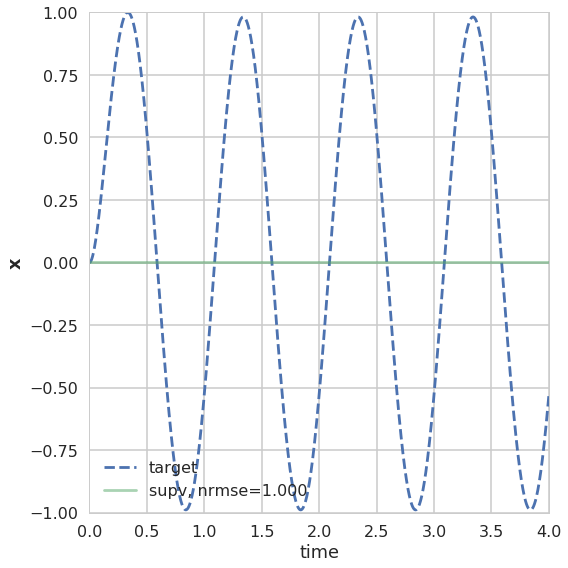

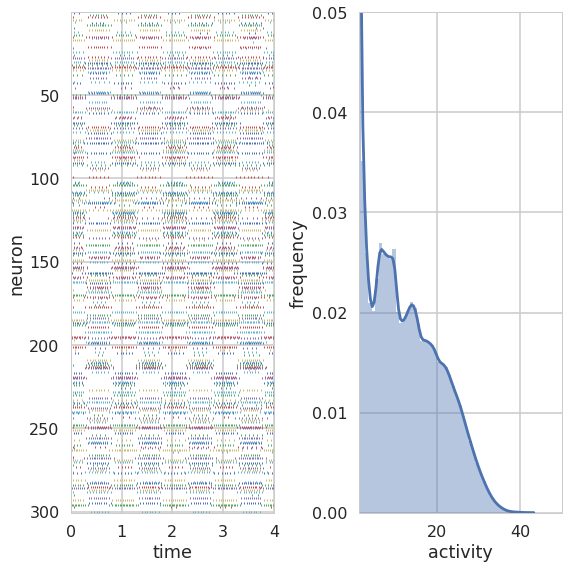

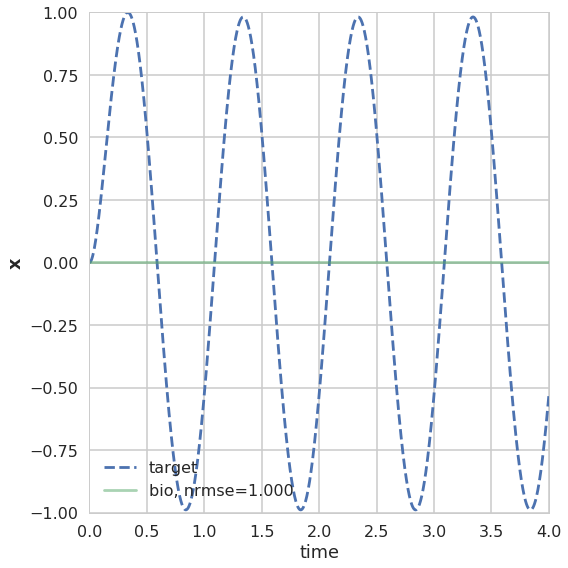

full supervision
Building finished in 0:00:07.                                                   
[###################### Simulating... 55%                       ] ETA: 0:53:15

In [ ]:
n_neurons = 300
t = 4
d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1,
          'bio-bio': 0.1,
          'bio-out': 0.1}

d_supv_out, d_supv_bio, _, _, _, _ = bio_fb(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    regs=regs,
    verbose=True)

print "full supervision"
_, _, d_bio_out, d_bio_bio, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    regs=regs,
    verbose=True)

print "full recurrence, training signal"
_, _, _, _, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    regs=regs,
    verbose=True)

print "full recurrence, novel signal"
_, _, _, _, _, _ = bio_fb(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=4,
    regs=regs,
    signal='white_noise',
    verbose=True)

